## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [0]:
## 使用Colab可先run這裡的code
#假如要連結自己的雲端硬碟再開啟
#from google.colab import drive
#drive.mount('/content/gdrive')
#檢查GPU
!nvidia-smi
##安裝產生驗證碼的套件

Wed Dec 25 11:52:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
#print(GPUs)
gpu = GPUs[0]

def printGPU():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  
printGPU()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=06680896bd141b3165b6e23dc160fa0c4aa64163f08db1b8d92aaa5f6aa5e73c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 155.9 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## 記得先 pip install captcha

In [0]:
pip install captcha

     |████████████████████████████████| 102kB 3.7MB/s 


## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, '3HNV')

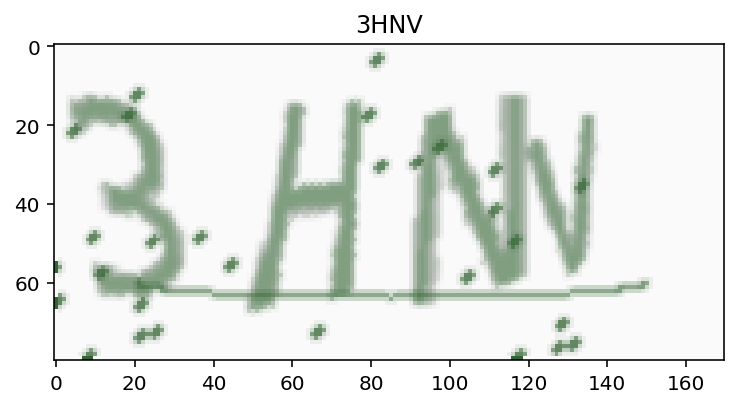

In [0]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [0]:
print(height, width)

80 170


In [0]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor

'''自己設計CNN層'''

x = Convolution2D(filters=64, kernel_size=(5,5), padding='valid',name='block1_conv_1_1')(x)
x = Convolution2D(filters=64, kernel_size=(5,5), padding='valid',name='block1_conv_1_2')(x)
x = BatchNormalization(name='block1_bn_1')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(filters=128, kernel_size=(3,3), padding='valid',name='block2_conv_1_1')(x)
x = Convolution2D(filters=128, kernel_size=(3,3), padding='valid',name='block2_conv_1_2')(x)
x = BatchNormalization(name='block2_bn_1')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(filters=256, kernel_size=(3,3), padding='valid',name='block3_conv_1_1')(x)
x = Convolution2D(filters=256, kernel_size=(3,3), padding='valid',name='block3_conv_1_2')(x)
x = BatchNormalization(name='block3_bn_1')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Convolution2D(filters=32, kernel_size=(3,3), padding='valid',name='block4_conv_1_1')(x)
x = Convolution2D(filters=32, kernel_size=(3,3), padding='valid',name='block4_conv_1_2')(x)
x = BatchNormalization(name='block4_bn_1')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,1))(x)


##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)


##包裝用來預測的model
base_model = Model(input=input_tensor, output=x)

print(base_model.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 80, 170, 3)        0         
_________________________________________________________________
block1_conv_1_1 (Conv2D)     (None, 76, 166, 64)       4864      
_________________________________________________________________
block1_conv_1_2 (Conv2D)     (None, 72, 162, 64)       102464    
_________________________________________________________________
block1_bn_1 (BatchNormalizat (None, 72, 162, 64)       256       
_________________________________________________________________
activation_45 (Activation)   (None, 72, 162, 64)       0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 36, 81, 64)        0         
_________________________________________________________________
block2_conv_1_1 (Conv2D)     (None, 34, 79, 128)       738

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [0]:
##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  


In [0]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
block1_conv_1_1 (Conv2D)        (None, 76, 166, 64)  4864        input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv_1_2 (Conv2D)        (None, 72, 162, 64)  102464      block1_conv_1_1[0][0]            
__________________________________________________________________________________________________
block1_bn_1 (BatchNormalization (None, 72, 162, 64)  256         block1_conv_1_2[0][0]            
___________________________________________________________________________________________

In [0]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[28 27 13 23]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]


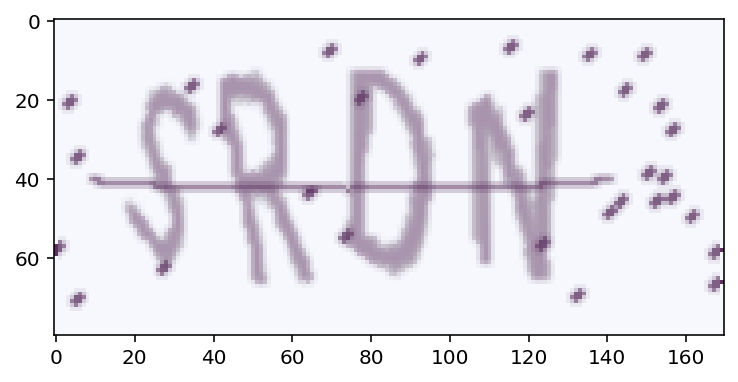

In [0]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [0]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=60)

Epoch 1/60
300/300 [==============================] - 39s 130ms/step - loss: 15.3476
Epoch 2/60
300/300 [==============================] - 37s 122ms/step - loss: 11.8428
Epoch 3/60
300/300 [==============================] - 37s 123ms/step - loss: 8.2681
Epoch 4/60
300/300 [==============================] - 37s 123ms/step - loss: 6.4754
Epoch 5/60
300/300 [==============================] - 37s 123ms/step - loss: 5.2566
Epoch 6/60
300/300 [==============================] - 37s 124ms/step - loss: 4.5239
Epoch 7/60
300/300 [==============================] - 38s 125ms/step - loss: 4.0359
Epoch 8/60
300/300 [==============================] - 37s 124ms/step - loss: 3.7404
Epoch 9/60
300/300 [==============================] - 37s 125ms/step - loss: 3.4623
Epoch 10/60
300/300 [==============================] - 37s 124ms/step - loss: 3.3325
Epoch 11/60
300/300 [==============================] - 37s 125ms/step - loss: 3.1675
Epoch 12/60
300/300 [==============================] - 37s 124ms/step - 

## 預測

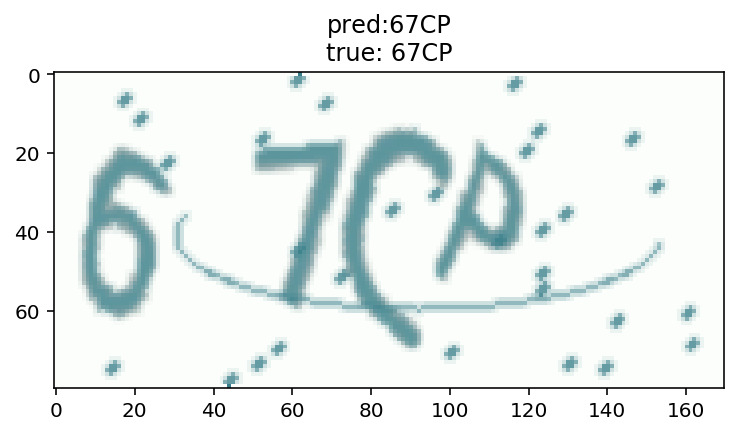

In [0]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]


In [0]:
characters[17]

'H'

In [0]:
 y_pred[0].argmax(1)

array([ 6, 36, 36, 36,  7,  7,  7, 12, 12, 36, 25, 25, 25])

## 自己寫 decode CTC

In [0]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

## 額外參考：加入RNN的神經網路

In [0]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru1_b')(x)
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru1_merged)
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru2", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru2_b", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(37, activation="softmax", ke

In [0]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 78, 168, 32)  128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 76, 166, 32)  9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=60)

Epoch 1/60
300/300 [==============================] - 49s 162ms/step - loss: 14.3050
Epoch 2/60
300/300 [==============================] - 45s 150ms/step - loss: 5.3457
Epoch 3/60
300/300 [==============================] - 45s 150ms/step - loss: 3.0677
Epoch 4/60
300/300 [==============================] - 45s 150ms/step - loss: 2.3014
Epoch 5/60
300/300 [==============================] - 45s 150ms/step - loss: 1.8900
Epoch 6/60
300/300 [==============================] - 45s 152ms/step - loss: 1.6421
Epoch 7/60
300/300 [==============================] - 45s 150ms/step - loss: 1.4238
Epoch 8/60
300/300 [==============================] - 45s 150ms/step - loss: 1.2644
Epoch 9/60
300/300 [==============================] - 45s 151ms/step - loss: 1.1557
Epoch 10/60
300/300 [==============================] - 45s 150ms/step - loss: 1.1168
Epoch 11/60
300/300 [==============================] - 45s 149ms/step - loss: 1.0002
Epoch 12/60
300/300 [==============================] - 45s 150ms/step - l

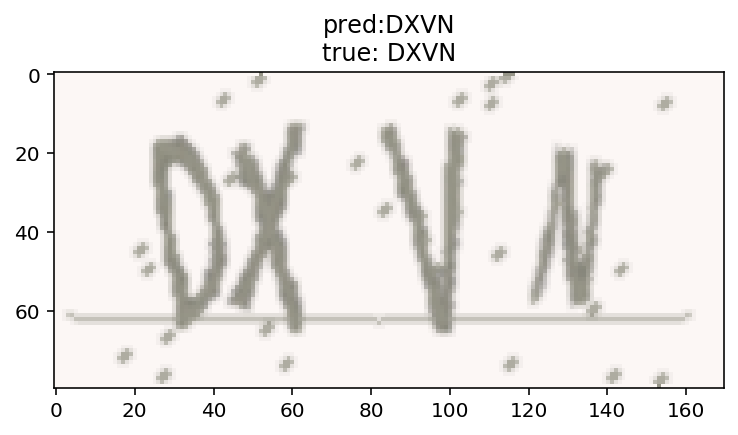

In [0]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]


In [0]:
#@title
